In [2]:
# https://www.kaggle.com/datasets/annavictoria/speed-dating-experiment

import pandas as pd

# selecting columns form import (dataset has 195 columns - based on preliminary data exploration i decidet go get only the ones I need)
col_to_import = ['iid', 'gender', 'age', 'goal', 'career_c', 'field_cd', 'sports', 'tvsports', 'exercise', 'dining', 'museums',
                 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']

# reading csv into pdandas dataframe
data_subset = pd.read_csv("speeddating.csv", encoding='latin-1', thousands=',', decimal='.', usecols=col_to_import)

# Data de-duplication (to keep only one row per experiment participant)
data_subset = data_subset.drop_duplicates(subset = ['iid'], keep='first')

In [3]:
#filling blanks for columns that not contain informations about interests
col = ['age', 'goal', 'career_c', 'field_cd']
data_subset[col] = data_subset[col].apply(lambda x: x.fillna(x.median()), axis=0)

#filling blanks for columns that contain interests informations
col = ['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']
data_subset[col] = data_subset[col].apply(lambda x: x.fillna(x.median()), axis=0)

# reseting index - important step for concatenation clustering results with raw_data
data_subset.reset_index(drop=True, inplace=True)

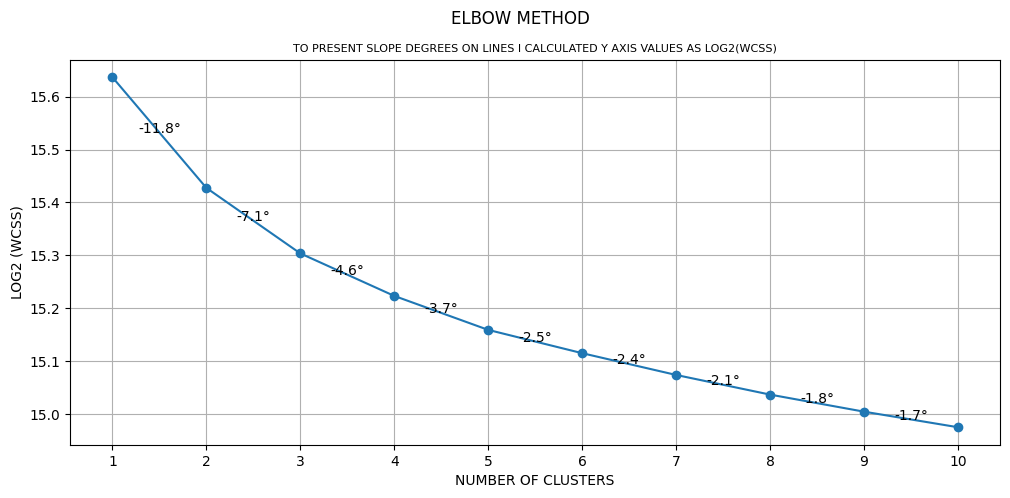

In [4]:

from sklearn.cluster import KMeans
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

colums_for_clustering = ['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming',
                         'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']

# At the initial stage I was planning to use StandardScaler(). But later on, I realized that the data itself
# is scaled, as those are survey results with scores from 1 to 10.
# scaler = StandardScaler()
# data_subset_scaled = scaler.fit_transform(data_subset.loc[:,colums_for_clustering ])
# data_subset_scaled = pd.DataFrame(data_subset_scaled, columns = colums_for_clustering)
data_subset_scaled = data_subset[colums_for_clustering]

# WCSS - Within-Clusters-Sum-of-Squares. Calculated for different clusters numer to look for best aproach
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data_subset_scaled)
    wcss.append( np.log2(kmeans.inertia_))

x = np.arange(1,11) # x coordinate (Number of clusters)
y = wcss            # WCSS - Within-Clusters-Sum-of-Squares

# Calculating slopes for each line
# this is not necceseary. Just wanted to practise python coding and explore matplotlib capabilities.
angles = []
for i in range(len(x) - 1):
    dx = x[i+1] - x[i]
    dy = y[i+1] - y[i]
    angle = np.degrees(np.arctan2(dy, dx))  # Slope in degrees
    angles.append(angle)

plt.figure(figsize=(12,5))
plt.plot(x, y, marker='o')

# adding slopes as line description
for i in range(len(angles)):
    # positioning in the middle of line
    x_pos = (x[i] + x[i+1]) / 2
    y_pos = (y[i] + y[i+1]) / 2
    plt.text(x_pos, y_pos, f"{angles[i]:.1f}°", color="black", fontsize=10, ha="center")

# formating thickmark value
def format_x(value, tick_number):
    return f"{value:.0f}"  # divide back to the cluster number

# formatting X axix
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_x))
plt.xticks(x)
plt.xlabel("NUMBER OF CLUSTERS")

# formatting Y axix
plt.ylabel("LOG2 (WCSS)")

# title and subtitle
plt.suptitle("ELBOW METHOD")
plt.title("TO PRESENT SLOPE DEGREES ON LINES I CALCULATED Y AXIS VALUES AS LOG2(WCSS)", fontsize=8)

plt.grid()

# plt.savefig("elbow.png", format="png", dpi=75, bbox_inches="tight") # 75 dpi gave me 752 x 372 demensions

plt.show()


In [5]:
# perform k-means clustering creating 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=400, n_init=10, random_state=0)
labels = pd.DataFrame(kmeans.fit_predict(data_subset_scaled), columns=['cluster'])

#Vector with cluster assignments - each observation (client) belongs to one cluster
dataset_with_category =  pd.concat([data_subset, labels], axis=1)

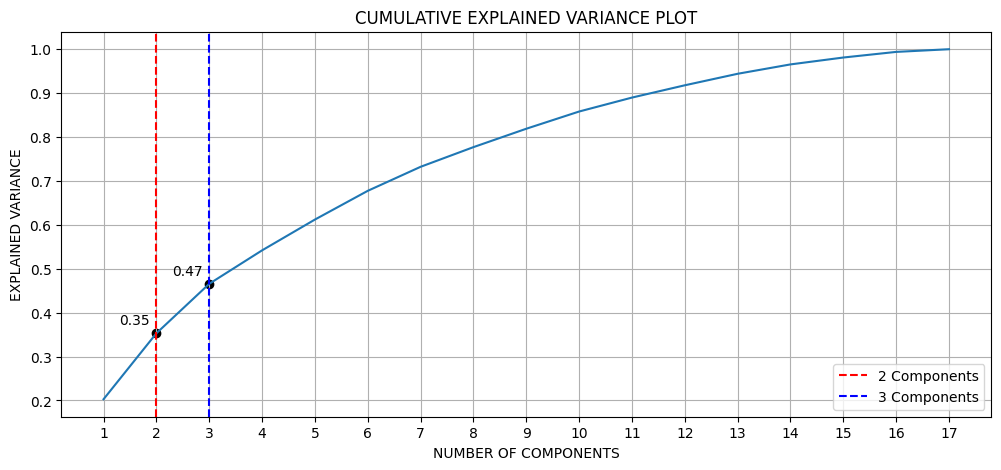

In [6]:
from sklearn.decomposition import PCA

# perform PCA
pca = PCA()                   # We can generate more than 2 components (up to the #variables in our dataset)
pca.fit(data_subset_scaled)   # feeding the data to algorithm

# creating simple numpy array that contains cumulative sum of explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
x= range(1,len(cumulative_variance)+1)

plt.figure(figsize=(12,5))
plt.plot( x, cumulative_variance)
plt.xlabel('NUMBER OF COMPONENTS')
plt.ylabel('EXPLAINED VARIANCE')
plt.xticks(x)

# Add vertical lines at components 2 and 3 - since I'm trying to visualize clustering effects, np point of reducing to 4 or more
plt.axvline(x=2, color='red', linestyle='--', label='2 Components')
plt.axvline(x=3, color='blue', linestyle='--', label='3 Components')

# title and subtitle
plt.title("CUMULATIVE EXPLAINED VARIANCE PLOT")

# Add values at intersections for 2 and 3 PCE - this is just for fun and matplotlib exploration
for x in [2, 3]:
    y_value = cumulative_variance[x - 1]  # Get the cumulative variance value for the component
    plt.scatter(x, y_value, color='black')  # Mark the intersection point
    plt.text(x - 0.12, y_value + 0.02, f"{y_value:.2f}", color='black', ha='right')  # Add text above the point

plt.legend()
plt.grid()

# plt.savefig("explained_variance.png", format="png", dpi=75, bbox_inches="tight") # 75 dpi gave me 752 x 372 demensions
plt.show()



<Figure size 1200x500 with 0 Axes>

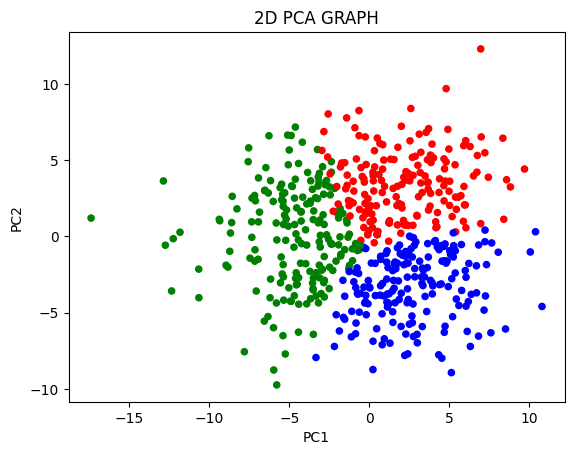

In [8]:

from sklearn.decomposition import PCA

# perform PCA
pca = PCA(n_components=2) #We can generate more than 2 components (up to the #variables in our dataset)
data_subset_pca = pca.fit_transform(data_subset_scaled)

#Getting it back into Pandas data frame
data_subset_tf = pd.concat([pd.DataFrame(data_subset_pca, columns=['PC1', 'PC2']),
                           labels]
                           , axis=1)

plt.figure(figsize=(12,5))
data_subset_tf.plot.scatter(x='PC1', y='PC2', c=data_subset_tf.cluster.replace([0, 1, 2], ['b', 'r', 'g']) )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("2D PCA GRAPH")

# plt.savefig("pca2d.png", format="png", dpi=75, bbox_inches="tight")

plt.show()

In [9]:

import plotly.express as px

# perform PCA for 3 components
pca = PCA(n_components=3)
data_subset_pca = pca.fit_transform(data_subset_scaled)

#Getting it back into Pandas data frame
data_subset_tf = pd.concat([pd.DataFrame(data_subset_pca, columns=['PC1', 'PC2', 'PC3']),
                           labels]
                           , axis=1)

color_map = {0: 'blue', 1: 'red', 2: 'green'}

fig = px.scatter_3d(
    data_subset_tf,
    x='PC1',
    y='PC2',
    z='PC3',
    color='cluster',
    title='INTERACTIVE PCA 3D CHART',
    labels={'PC1': 'component 1', 'PC2': 'component 2', 'PC3': 'component 3'},
    opacity=0.7,
    height=600,
    width=800,
)

fig.update_traces(marker=dict(size=5))  # Marker size
fig.update_layout(scene=dict(
    xaxis_title='PC1',
    yaxis_title='PC2',
    zaxis_title='PC3',
))

fig.show()


In [11]:
# building dataframe with aggregations for polar plots

# The method chain - I did some additional transformations to create cluster with sample size (for legent on plot)
df_viz = (
    dataset_with_category       #source DataFrame
    #this is like window function in SQL. Calculates rows count for each cluster
    .assign(cluster_row_count=lambda df: df.groupby('cluster')['cluster'].transform('count'))
    #cocnact of cluster nr and cluster size
    .assign(cluster_name=lambda row: "cluster: " + row['cluster'].astype(str) + "  |  c_size: " + row['cluster_row_count'].astype(str))
    .groupby(['cluster', 'cluster_name'])
    .agg([
        ('min', 'min'),
        ('Q1', lambda x: x.quantile(0.25)), # Q1
        ('median', 'median'),
        ('mean', 'mean'),
        ('Q3', lambda x: x.quantile(0.75))  # Q3
    ])
    .stack(future_stack=True)
    .reset_index()
    .melt(id_vars=['cluster', 'cluster_name', 'level_2'])
    .query('variable in @colums_for_clustering')
    .rename(columns={'level_2': 'agg_function'})
)


In [12]:
# For the polar pot (spider graph) I used plotly.express. To save the chart as .png / .jpg … its necessary to
# install kaleido on the project environment. Unfraternally at the time I was preparing the project there was some
# “misunderstanding” between Kaleido and Plotly newer versions.
# Can’t remember what versions I used, just remember that I had to do some reinstallations.

#pip install -U kaleido
#import kaleido

import plotly.express as px


df_viz_ = df_viz.query('agg_function == "mean"')[['cluster_name', 'variable', 'value']]

# Create the polar plot
fig = px.line_polar(
                    df_viz_,
                    r = "value",
                    theta = "variable",
                    line_close = True,
                    color = "cluster_name",
                    color_discrete_sequence= ['red', 'green', 'blue', 'black'],
                    width=1000,
                    height=500
                    )

fig.update_layout(
                    polar = dict(
                    radialaxis = dict(
                    visible = True,
                    range = [1, 10]
                    )),
                    showlegend = True,
                    title={
                          'text': "MEDIAN OF SURVEY SCORE FOR EACH CLUSTER",
                          'y': 0.95,  # Title Height (% of total)
                          'x': 0.5,   # horizontal alighment (% of total width)
                          'xanchor': 'center',
                          'yanchor': 'top'
                          }
                    )

# fig.write_image("polar.png")
fig.show()

In [13]:
#Variable disttibution for each cluster

import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Cluster 1
df1 = df_viz.query('cluster == 0 and agg_function != "mean"')[['cluster_name', 'agg_function', 'variable', 'value']]

fig1 = px.line_polar(df1,
                    r = "value",
                    theta = "variable",
                    line_close = True,
                    color = "agg_function",
                    color_discrete_sequence= ['red', 'green', 'blue', 'black', 'orange'],
                    width=800,
                    height=400
                    )

fig1.update_layout( polar = dict(
                    radialaxis = dict(
                    visible = True,
                    range = [1, 10]
                    ))
                    )

#Cluster 2
df2 = df_viz.query('cluster == 1 and agg_function != "mean"')[['cluster_name', 'agg_function', 'variable', 'value']]

fig2 = px.line_polar(df2,
                    r = "value",
                    theta = "variable",
                    line_close = True,
                    color = "agg_function",
                    color_discrete_sequence= ['red', 'green', 'blue', 'black', 'orange'],
                    width=800,
                    height=400
                    )

fig2.update_layout( polar = dict(
                    radialaxis = dict(
                    visible = True,
                    range = [1, 10]
                    ))
                    )

#Cluster 3
df3 = df_viz.query('cluster == 2 and agg_function != "mean"')[['cluster_name', 'agg_function', 'variable', 'value']]

fig3 = px.line_polar(df3,
                    r = "value",
                    theta = "variable",
                    line_close = True,
                    color = "agg_function",
                    color_discrete_sequence= ['red', 'green', 'blue', 'black', 'orange'],
                    width=800,
                    height=400
                    )

fig3.update_layout( polar = dict(
                    radialaxis = dict(
                    visible = True,
                    range = [1, 10]
                    ))
                    )


# Subplots Layout
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'polar'}, {'type': 'polar'},{'type': 'polar'}]],
    subplot_titles=("COLLECTING SPIRITUAL EXPERIENCES", "EVERYTHING BUT GAMING AND YOGA", "BODY-MIND-SPIRIT")
)

# Dodanie wykresów do układu
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)
for trace in fig3.data:
    fig.add_trace(trace, row=1, col=3)


# Ustawienia layoutu
fig.update_layout(
    height=650, width=1500,
    title={
            'text': "VARIABLE DISTTIBUTION FOR EACH CLUSTER",
            'y': 0.95,  # Title Height (% of total)
            'x': 0.5,   # horizontal alighment (% of total width)
            'xanchor': 'center',
            'yanchor': 'top'
            }
)

# Wyświetlenie wykresu
fig.show()